# Mini projekt 2
Jan Jędrzejewski, Dominik Łopatecki

In [106]:
import torch
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import dataloader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device

device(type='cpu')

# Funkcje

In [107]:
def map_time(time):
  time = time.strip()
  if time == "0-5min" or time == "0~5min":
    return 0
  elif time == "5min~10min":
    return 1
  elif time == "10min~15min":
    return 2
  elif time == "15min~20min":
    return 3
  else:
    return 4

def categorize(price):
  if price <= 100000:
    return 0
  elif price <= 350000:
    return 1
  else:
    return 2

def count_classes(vec):
  count0, count1, count2 = 0, 0, 0
  for x in vec:
    if x == 0: count0 += 1
    elif x == 1: count1 += 1
    elif x == 2: count2 += 1
  return count0, count1, count2

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = [categorize(x) for x in output]
        labels = [categorize(x) for x in labels]
        for i in range(len(pred)):
          if pred[i] == labels[i]:
            correct += 1
        total += x.shape[0]
    return correct / total

def get_accuracy_classifier(model, data_loader):
    correct, total = 0, 0
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        _, preds = torch.max(output, dim=1)
        correct += torch.sum(preds==labels).item()
        total += labels.size(0)
    return correct / total

def conf_matrix_reg(model, data_loader):
    out, lab = [], []
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        out += [categorize(x) for x in output]
        lab += [categorize(x) for x in labels]
    return confusion_matrix(lab, out)

def conf_matrix(model, data_loader):
    out, lab = [], []
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        _, pred = torch.max(output, dim=1)
        out += pred
        lab += labels
    return confusion_matrix(lab, out)

act_fn_by_name = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": F.relu,
    "leakyrelu": F.leaky_relu
}

# Dane

In [108]:
train_data = pd.read_csv('train_data.csv')
train_data

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


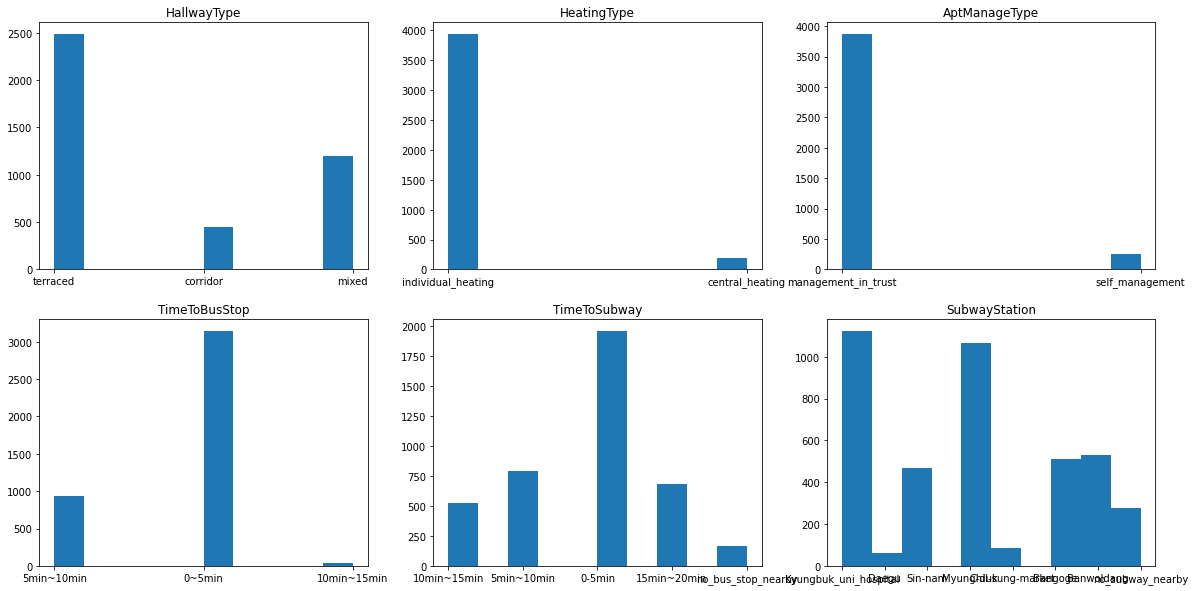

In [109]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.hist(train_data["HallwayType"].to_numpy())
plt.title("HallwayType")

plt.subplot(2, 3, 2)
plt.hist(train_data["HeatingType"].to_numpy())
plt.title("HeatingType")

plt.subplot(2, 3, 3)
plt.hist(train_data["AptManageType"].to_numpy())
plt.title("AptManageType")

plt.subplot(2, 3, 4)
plt.hist(train_data["TimeToBusStop"].to_numpy())
plt.title("TimeToBusStop")

plt.subplot(2, 3, 5)
plt.hist(train_data["TimeToSubway"].to_numpy())
plt.title("TimeToSubway")

plt.subplot(2, 3, 6)
plt.hist(train_data["SubwayStation"].to_numpy())
plt.title("SubwayStation")

plt.show()

In [110]:
numerical = train_data.drop(["SalePrice", "SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"], axis=1)
numerical.values.shape

(4124, 10)

In [111]:
categorical = train_data.filter(["SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"])
categorical_values = pd.get_dummies(categorical)
categorical_values.shape

(4124, 23)

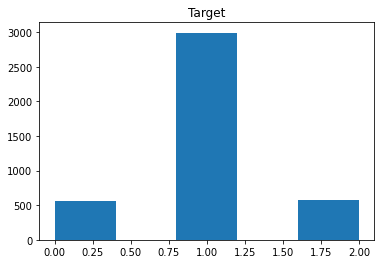

Class zero: 13.63%
Class one: 72.55%
Class two: 13.82%


In [112]:
target = train_data.values[:, 0]

categorical_target = [categorize(x) for x in target]
plt.hist(categorical_target, bins=5)
plt.title("Target")
plt.show()

count0, count1, count2 = count_classes(categorical_target)

print(f"Class zero: {round(count0/len(categorical_target)*100, 2)}%")
print(f"Class one: {round(count1/len(categorical_target)*100, 2)}%")
print(f"Class two: {round(count2/len(categorical_target)*100, 2)}%")

In [113]:
numerical_data = torch.from_numpy(numerical.values.astype(float)).float()
categorical_data = torch.from_numpy(categorical_values.values).float()
targets_data = torch.from_numpy(target.astype(float)).float()
categorical_target_data = torch.Tensor(categorical_target).long()

In [114]:
numerical_data, test_numerical_data, categorical_data, test_categorical_data, targets, test_targets, targets_categorical, test_targets_categorical= train_test_split(numerical_data, categorical_data, targets_data, categorical_target_data, test_size=0.2, random_state=25)

train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [115]:
train_dataset_classes = data.TensorDataset(numerical_data,categorical_data,targets_categorical)
test_dataset_classes = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets_categorical)

train_loader_c = torch.utils.data.DataLoader(train_dataset_classes, batch_size=64, shuffle=True)
test_loader_c = torch.utils.data.DataLoader(test_dataset_classes, batch_size=128, shuffle=False)

# Modele

In [116]:
class Regressor(nn.Module):
    def __init__(self, num_hidden1, num_hidden2, num_hidden3, act_func, dropout):
        super().__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.linear1 = nn.Linear(categorical_data.shape[1] + numerical.values.shape[1], num_hidden1)
        self.bn1 = nn.BatchNorm1d(num_hidden1)
        self.act_fn1 = act_fn_by_name[act_func]
        self.d1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.bn2 = nn.BatchNorm1d(num_hidden2)
        self.act_fn2 = act_fn_by_name[act_func]
        self.d2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.bn3 = nn.BatchNorm1d(num_hidden3)
        self.act_fn3 = act_fn_by_name[act_func]
        self.d3 = nn.Dropout(dropout)
        self.linear4 = nn.Linear(num_hidden3, 1)

    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.act_fn1(x)
        x = self.d1(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.act_fn2(x)
        x = self.d2(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.act_fn3(x)
        x = self.d3(x)
        x = self.linear4(x)
        # w trybie eval bachnorm i dropout nie działą
        return x

In [117]:
class Classifier(nn.Module):
    def __init__(self, num_hidden1, num_hidden2, num_hidden3, act_func, dropout):
        super().__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.linear1 = nn.Linear(categorical_data.shape[1] + numerical.values.shape[1], num_hidden1)
        self.bn1 = nn.BatchNorm1d(num_hidden1)
        self.act_fn1 = act_fn_by_name[act_func]
        self.d1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.bn2 = nn.BatchNorm1d(num_hidden2)
        self.act_fn2 = act_fn_by_name[act_func]
        self.d2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.bn3 = nn.BatchNorm1d(num_hidden3)
        self.act_fn3 = act_fn_by_name[act_func]
        self.d3 = nn.Dropout(dropout)
        self.linear4 = nn.Linear(num_hidden3, 3)

    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.act_fn1(x)
        x = self.d1(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.act_fn2(x)
        x = self.d2(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.act_fn3(x)
        x = self.d3(x)
        x = self.linear4(x)
        # w trybie eval bachnorm i dropout nie działą
        return x

In [126]:
def train(model, optimizer, loss_module, loader, loader_test, num_epochs, accuracy):
  iters, Loss, train_acc, val_acc = [], [], [], []
  model.train()
  for epoch in tqdm(range(num_epochs)):
    epoch_losses = []
    for x, cat_x, labels in iter(loader):
      x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)

      preds = model(x, cat_x).squeeze()

      loss = loss_module(preds, labels)
      loss.backward()
      epoch_losses.append(loss.item())

      optimizer.step()
      optimizer.zero_grad()
      
    iters.append(epoch)
    Loss.append(np.array(epoch_losses).mean())
    train_acc.append(accuracy(model, loader))
    if loader_test:
      val_acc.append(accuracy(model, loader_test))
    else:
      val_acc.append(0)

  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.plot(iters, Loss)
  plt.title("loss")

  plt.subplot(1,2,2)
  plt.title("training curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()
  
  print(f"Final train accuracy: {round(train_acc[-1]*100, 2)}%")
  print(f"Final validation accuracy: {round(val_acc[-1]*100, 2)}%")

# Trenowanie

## 1) Regresja 
- jeden neuron na wyjściu
- przewiduje cenę mieszkania

100%|██████████| 500/500 [02:57<00:00,  2.82it/s]


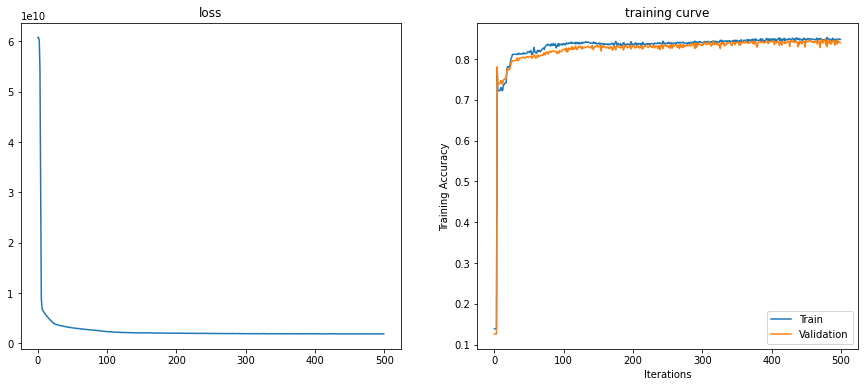

Final train accuracy: 84.78%
Final validation accuracy: 84.0%


In [119]:
regressor = Regressor(num_hidden1=256, num_hidden2=128, num_hidden3=32, act_func="leakyrelu", dropout=0.6)
regressor.to(device)

Optimizer = torch.optim.Adam(regressor.parameters(), weight_decay=0.01, lr=0.001)
Loss_module = nn.MSELoss()

train(regressor, Optimizer, Loss_module, train_loader, test_loader, num_epochs=500, accuracy=get_accuracy)

## 2) Klasyfikator
- trzy neurony na wyjściu
- przewidywanie klasy cenowej mieszkania

100%|██████████| 500/500 [17:18<00:00,  2.08s/it]


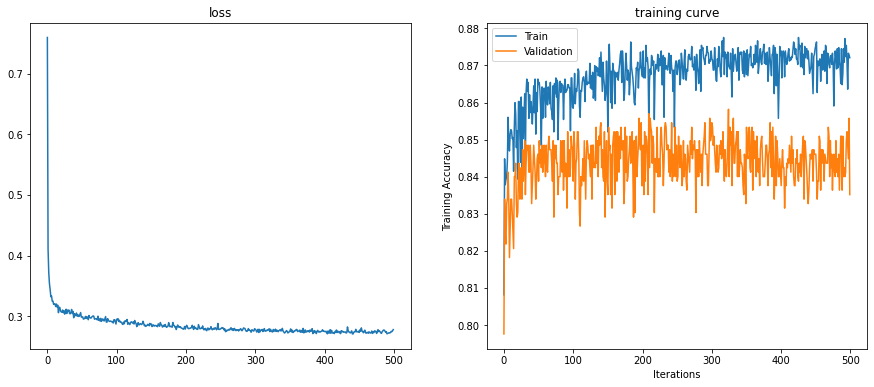

Final train accuracy: 87.21%
Final validation accuracy: 83.52%


In [120]:
classifier = Classifier(num_hidden1=256, num_hidden2=128, num_hidden3=32, act_func="leakyrelu", dropout=0.4)
classifier.to(device)

Optimizer_c = torch.optim.Adam(classifier.parameters(), weight_decay=0.001, lr=0.001)
Loss_module_c = nn.CrossEntropyLoss()

train(classifier, Optimizer_c, Loss_module_c, train_loader_c, test_loader_c, num_epochs=500, accuracy=get_accuracy_classifier)

## 3) Klasyfikator z ważeniem klas
- nieproporcjonalnie duża liczba mieszkań klasy 1
- stosunek klas to ok 0.14, 0.72, 0.14
- stosujemy wagi dla funkcji straty [4, 1, 4]

100%|██████████| 500/500 [15:56<00:00,  1.91s/it]


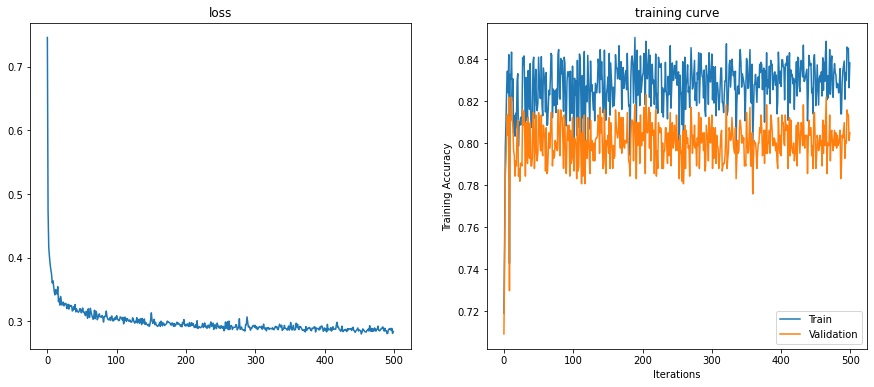

Final train accuracy: 83.81%
Final validation accuracy: 80.48%


In [121]:
classifier_w = Classifier(num_hidden1=256, num_hidden2=128, num_hidden3=32, act_func="leakyrelu", dropout=0.4)
classifier_w.to(device)

Optimizer_c = torch.optim.Adam(classifier_w.parameters(), weight_decay=0.001, lr=0.001)
Loss_module_c = nn.CrossEntropyLoss(weight=torch.Tensor([4, 1, 4]))

train(classifier_w, Optimizer_c, Loss_module_c, train_loader_c, test_loader_c, num_epochs=500, accuracy=get_accuracy_classifier)

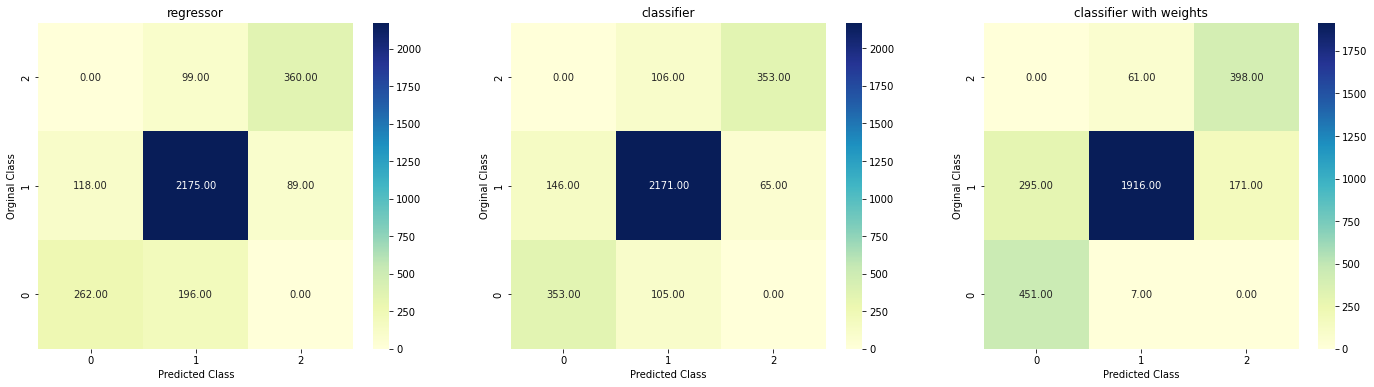

In [122]:
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
sns.heatmap(
        np.flip(conf_matrix_reg(regressor, train_loader), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2],
        yticklabels=[2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("regressor")

plt.subplot(1,3,2)
sns.heatmap(
        np.flip(conf_matrix(classifier, train_loader_c), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2],
        yticklabels=[2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("classifier")

plt.subplot(1,3,3)
sns.heatmap(
        np.flip(conf_matrix(classifier_w, train_loader_c), 0),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        xticklabels=[0, 1, 2],
        yticklabels=[2, 1, 0],
    )
plt.xlabel("Predicted Class")
plt.ylabel("Orginal Class")
plt.title("classifier with weights")
plt.show()

Dla trzech rodzajów modeli sprawdzaliśmy wpływ parametrów na wyniki. Regresor działa troche lepiej dla większej wartości dropout. Każda z metod prezentuje podobne wyniki dla relu i leakyrelu jako funkcja aktywacji. W macierzach pomyłek możemy dostrzec różnice pomiedzy klasyfiaktorem bez wag a z wagami. Ten pierwszy częściej wybiera klase 1 ponieważ w zbiorze trenującym występuje najczęściej. Po zastosowaniu wag klasyfikator ma mniejszy błąd w rozpoznawaniu klas 0 i 2 ale większy na klasie 1 co przekłada się na ogólnie gorszę skuteczność o ok 4%. Do predykcji zbioru testowego wykorzystamy model nr 3 - aby uzyskać najwyższą dokładność dla każdej z klas.

# Finalny model

## Trening

In [123]:
train_data = pd.read_csv('train_data.csv')
numerical = train_data.drop(["SalePrice", "SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"], axis=1)
categorical = train_data.filter(["SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"])
categorical_values = pd.get_dummies(categorical)
target = train_data.values[:, 0]
categorical_target = [categorize(x) for x in target]

numerical_data = torch.from_numpy(numerical.values.astype(float)).float()
categorical_data = torch.from_numpy(categorical_values.values).float()
categorical_target_data = torch.Tensor(categorical_target).long()

train_dataset = data.TensorDataset(numerical_data,categorical_data,categorical_target_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 500/500 [13:12<00:00,  1.59s/it]


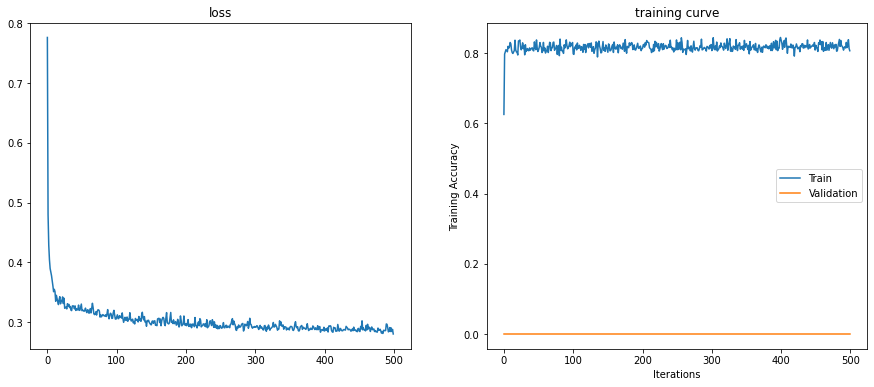

Final train accuracy: 80.67%
Final validation accuracy: 0%


In [127]:
classifier = Classifier(num_hidden1=256, num_hidden2=128, num_hidden3=32, act_func="leakyrelu", dropout=0.4)
classifier.to(device)

Optimizer_c = torch.optim.Adam(classifier.parameters(), weight_decay=0.001, lr=0.001)
Loss_module_c = nn.CrossEntropyLoss(weight=torch.Tensor([4, 1, 4]))

train(classifier, Optimizer_c, Loss_module_c, train_loader, None, num_epochs=500, accuracy=get_accuracy_classifier)

## Wyniki

In [135]:
test_data = pd.read_csv('test_data.csv')
test_data

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1,2014,907,16,terraced,individual_heating,management_in_trust,90.0,1174.0,0~5min,0-5min,7.0,20.0,Myung-duk,9,14.0,17.0
2,2007,1629,7,terraced,individual_heating,management_in_trust,7.0,605.0,0~5min,0-5min,5.0,5.0,Banwoldang,5,9.0,5.0
3,2005,743,21,mixed,individual_heating,management_in_trust,67.0,798.0,0~5min,5min~10min,6.0,0.0,Bangoge,7,13.0,15.0
4,2006,903,7,terraced,individual_heating,management_in_trust,123.0,181.0,5min~10min,0-5min,3.0,11.0,Myung-duk,4,8.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2006,2056,2,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
1763,2007,1394,7,terraced,individual_heating,management_in_trust,554.0,524.0,0~5min,0-5min,5.0,10.0,Banwoldang,4,9.0,8.0
1764,1993,644,20,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1765,2008,914,11,terraced,individual_heating,management_in_trust,197.0,475.0,5min~10min,0-5min,6.0,14.0,Sin-nam,8,7.0,9.0


In [136]:
numerical = test_data.drop(["SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"], axis=1)
categorical = test_data.filter(["SubwayStation","HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway"])
categorical_values = pd.get_dummies(categorical)

numerical_data = torch.from_numpy(numerical.values.astype(float)).float()
categorical_data = torch.from_numpy(categorical_values.values).float()

test_dataset = data.TensorDataset(numerical_data,categorical_data)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_data), shuffle=False)

In [153]:
classifier.eval()
with torch.no_grad():
  for x, cat_x in test_loader:
      x, cat_x = x.to(device), cat_x.to(device)
      output = classifier(x, cat_x)
      _, PREDS = torch.max(output, dim=1)

PREDS

tensor([1, 1, 2,  ..., 0, 1, 1])

In [154]:
df = pd.DataFrame(PREDS)
df.to_csv("piatek_Jedrzejewski_Lopatecki.csv", index=False, header=None)